<a href="https://colab.research.google.com/github/dong-uk-kim97/Exploration/blob/main/exploration_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 번역기를 만들어보자

In [1]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import unicodedata
import urllib3
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [2]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

총 33,000개의 샘플을 사용할 예정

In [3]:
num_samples = 33000

## 전처리 함수 구현

In [4]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

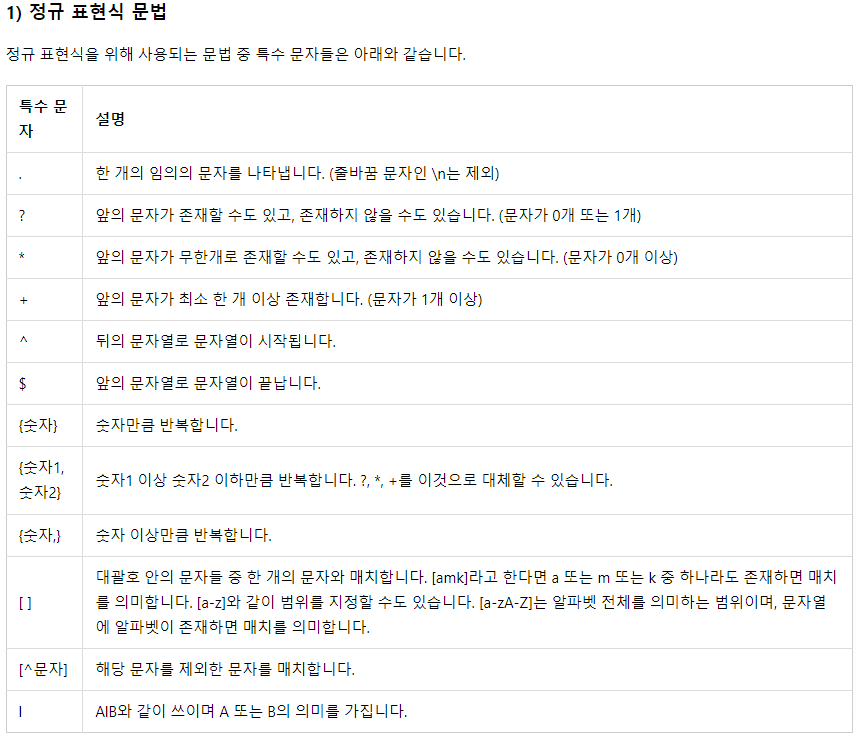

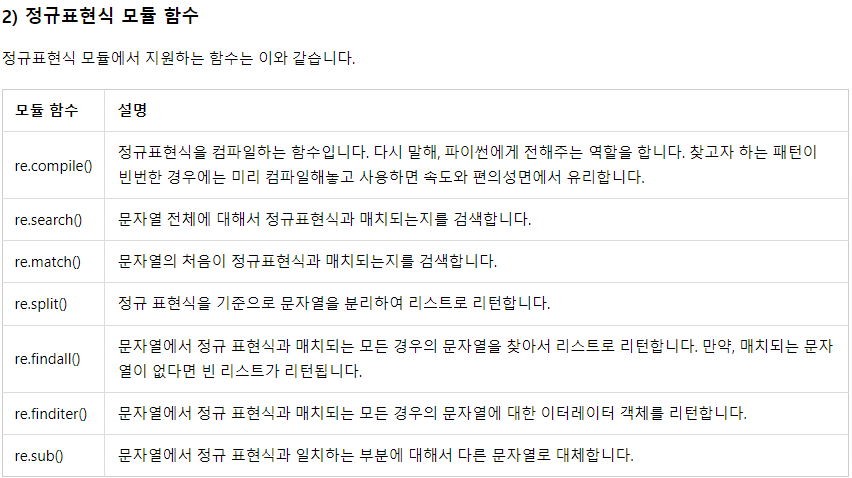

### 샘플 데이터를 불러와 모든 전처리를 수행하는 함수 구현

- teacher forcing을 위해 디코더의 입/출력 시퀀스를 따로 분리하여 저장
- 입출력 심볼 추가
- 총 3개의 데이터 셋 생성: 인코더의 입력, 디코더의 입력, 디코더의 실제값

In [6]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

단어 토큰화는 기본적으로 띄어쓰기를 기준으로 합니다. 영어는 보통 띄어쓰기로 토큰이 구분되는 반면, 한국어는 띄어쓰기 만으로 토큰을 구분하기는 어렵습니다

### 데이터셋 출력하여 확인

In [7]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


## 단어집합 생성 & 정수 인코딩

In [8]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

- fit_on_texts는 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여하는데, 정확히 앞서 설명한 정수 인코딩 작업이 이루어진다고 보면됩니다. 각 단어에 인덱스가 어떻게 부여되었는지를 보려면, word_index를 사용합니다. \\
- texts_to_sequences()는 입력으로 들어온 코퍼스에 대해서 각 단어를 이미 정해진 인덱스로 변환합니다.

### 패딩

In [9]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

### 단어 집합의 크기 정의

In [10]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4672, 프랑스어 단어 집합의 크기 : 8153


num_words에서 +1을 더해서 값을 넣어주는 이유는 num_words는 숫자를 0부터 카운트합니다. 만약 5를 넣으면 0 ~ 4번 단어 보존을 의미하게 되므로 뒤의 실습에서 1번 단어부터 4번 단어만 남게됩니다. 그렇기 때문에 1 ~ 5번 단어까지 사용하고 싶다면 num_words에 숫자 5를 넣어주는 것이 아니라 5+1인 값을 넣어주어야 합니다. \\
실질적으로 숫자 0에 지정된 단어가 존재하지 않는데도 케라스 토크나이저가 숫자 0까지 단어 집합의 크기로 산정하는 이유는 자연어 처리에서 **패딩(padding)**이라는 작업 때문입니다

### 단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 생성

In [11]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

### 테스트 데이터 분리
- 적절한 분포를 갖도록 데이터를 섞어 줌

In [12]:
# 순서가 섞인 정수 시퀀스 리스트 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[20033 30591 21180 ...  8866 32969 30619]


In [13]:
# 이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞임

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [14]:
# 확인

encoder_input[30997]

array([   5,    7, 1233,    1,    0,    0,    0,    0], dtype=int32)

In [15]:
decoder_input[30997]

array([   2,    7,    8,   60, 2844,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [16]:
decoder_target[30997]

array([   7,    8,   60, 2844,    1,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

- 훈련 데이터의 10%를 테스트 데이터로 분리

In [17]:
n_of_val = int(33000*0.1)
print(n_of_val)

3300


In [18]:
# 33,000개의 10%에 해당되는 3,300개의 데이터를 테스트 데이터로 사용

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [19]:
# 훈련 데이터와 테스트 데이터의 크기(shape)를 출력

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(29700, 8)
(29700, 16)
(29700, 16)
(3300, 8)
(3300, 16)
(3300, 16)


## 기계 번역기 만들기

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [21]:
# 임베딩 벡터와 LSTM의 은닉 상태의 크기를 50으로 고정

latent_dim = 50

### 모델 설계

In [22]:
# 인코더

encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [23]:
# 디코더

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [24]:
# 모델 정의

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

- 훈련 실행

In [25]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

# 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태이므로
# sparse_categorical_crossentropy를 사용

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 50)     233600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 50)     407650      ['input_2[0][0]']                
                                                                                              

In [27]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50)

Epoch 1/50
233/233 [==============================] - 23s 41ms/step - loss: 3.1236 - acc: 0.6190 - val_loss: 1.8956 - val_acc: 0.7130
Epoch 2/50
233/233 [==============================] - 7s 30ms/step - loss: 1.6664 - acc: 0.7387 - val_loss: 1.5657 - val_acc: 0.7506
Epoch 3/50
233/233 [==============================] - 7s 29ms/step - loss: 1.4764 - acc: 0.7597 - val_loss: 1.4669 - val_acc: 0.7614
Epoch 4/50
233/233 [==============================] - 7s 30ms/step - loss: 1.3801 - acc: 0.7725 - val_loss: 1.3811 - val_acc: 0.7794
Epoch 5/50
233/233 [==============================] - 7s 30ms/step - loss: 1.2982 - acc: 0.7888 - val_loss: 1.3188 - val_acc: 0.7920
Epoch 6/50
233/233 [==============================] - 7s 30ms/step - loss: 1.2317 - acc: 0.7997 - val_loss: 1.2584 - val_acc: 0.7994
Epoch 7/50
233/233 [==============================] - 7s 30ms/step - loss: 1.1771 - acc: 0.8076 - val_loss: 1.2151 - val_acc: 0.8053
Epoch 8/50
233/233 [==============================] - 7s 30ms/step -

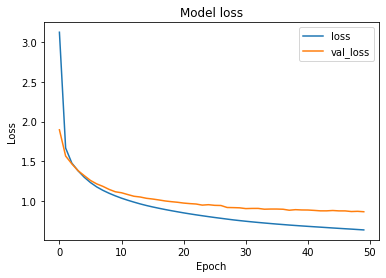

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], loc='best')
plt.show()

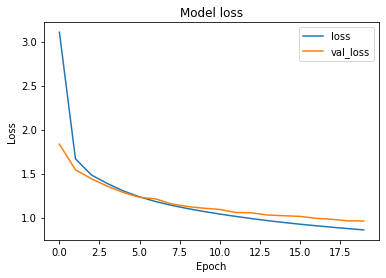

epochs=20일 때의 그래프이다. val_loss가 우하향하는 것을 볼 수 있다. val_loss가 loss를 넘어서는 5 이후로 과적합이 일어나는 것을 확인할 수 있다. epochs=20일 때 학습이 완벽히 이루어지지 않고 있기 때문에 50으로 놓고 다시 시도한다.

## seq2seq 기계 번역기 동작시키기

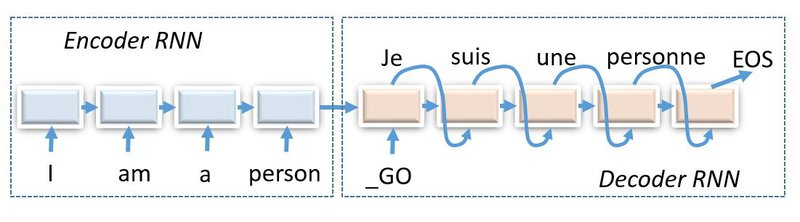

seq2seq는 두 개의 RNN 아키텍처를 연결한 구조입니다. 입력 문장을 받는 RNN을 **인코더**라고 하고, 두번째 RNN을 **디코더**라고 합니다.

아래 그림에서 Encoder는 Feature Extractor의 역할을 합니다. 어떤 데이터 X를 해석하기 위한 저차원의 feature vector z를 만들어 냅니다. 반면에 Decoder는 저차원의 Feature z로부터 정보를 복원해서 다시 어떤 데이터 $X^\prime$을 재생성하는 역할을 합니다.

In [29]:
# 테스트를 위해 모델 재설계

# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 겁니다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 합니다. 이런 상황이 반복되면 훈련 시간이 느려집니다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 **교사 강요**라고 합니다.

In [30]:
# 디코더 정의

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

### 테스트 과정에서의 동작을 위한 decode_sequence 함수를 구현

In [31]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

### 결과 확인을 위한 함수 구현

In [32]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

### 훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력

In [33]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_train[seq_index]))
  print("번역문 :",seq2tar(decoder_input_train[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  i really tried . 
번역문 : j ai vraiment essaye . 
예측문 :  j ai vraiment essaye . 


원문 :  i don t trust you . 
번역문 : je n ai pas confiance en toi . 
예측문 :  je ne vous ai pas aime . 


원문 :  i could walk . 
번역문 : je pourrais marcher . 
예측문 :  je voulais faire ca . 


원문 :  let me stop here . 
번역문 : laisse moi m arreter ici . 
예측문 :  laissez moi faire ca faire . 


원문 :  what a rip off ! 
번역문 : quelle arnaque ! 
예측문 :  quelle journee ! 




### 테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력

In [34]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_test[seq_index]))
  print("번역문 :",seq2tar(decoder_input_test[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  i wasn t asleep . 
번역문 : je n etais pas assoupie . 
예측문 :  je n etais pas en train de pas . 


원문 :  you re beautiful . 
번역문 : tu es beau . 
예측문 :  vous etes bon . 


원문 :  i hate this town . 
번역문 : je deteste cette bourgade . 
예측문 :  je deteste cette maison . 


원문 :  is this pen yours ? 
번역문 : est ce que ce stylo est a vous ? 
예측문 :  est ce que c est ma voiture ? 


원문 :  they re harmless . 
번역문 : elles ne sont pas dangereuses . 
예측문 :  ils sont sont m en ? 




### 1차 번역(epochs=20)

|  |  | 영어번역 |
|---|---|---|
| 원문 | i m very impressed |  |
| 번역본 | je suis for impressionee. | i am very impressed. |
| 예측문 | je suis tres tres. | i am very very |

번역본은 잘 번역했으나 예측문에서 동사를 예측하지 못했다.

|  |  | 영어번역 |
|---|---|---|
| 원문 | how may i help you ? |  |
| 번역본 | comment puis je vous aider ? | how can i help you? |
| 예측문 | comment puis je m aider ? | how can i help myself? |

번역본에서 may와 can 조동사 차이가 있다. may와 can은 의미적으로 조금의 차이가 있기 때문에 예측을 잘못한 것이라고 말할 수 있다. 그리고 you와 myself도 의미적으로 완전 차이가 난다.

|  |  | 영어번역 |
|---|---|---|
| 원문 | i love this album . |  |
| 번역본 | j aime cet album . | I like this album. |
| 예측문 | j adore cette francais . | I love this french. |

번역본과 예측본에서 주어 동사는 유사하지만 목적어가 다르다. 그래서 의미적으로 다른 문장을 출력했다.

|  |  | 영어번역 |
|---|---|---|
| 원문 | give it a whirl . |  |
| 번역본 | essaie donc . | so try. |
| 예측문 | essaie de une seconde ! | try for a second! |

give it a whirl은 한번 해보다 라는 뜻이다. so try와 try for a second 역시 한번 시도해보다는 뜻이다. 의미적으로 유사한 것을 파악할 수 있다.

|  |  | 영어번역 |
|---|---|---|
| 원문 | tom is a teenager . |  |
| 번역본 | tom est un adolescent . | tom is a teenager . |
| 예측문 | tom est un coup de feu . | tom is a shot. |

번역본은 원문과 보어가 같지만, 예측문은 보어가 다르다. 그래서 의미적으로 완전히 다른 문장이다.

4개의 문장 중 하나의 문장만 의미적으로 유사하다는 것을 파악할 수 있다.

### 2차 시도 (epochs=50)

|  |  | 영어번역 |
|---|---|---|
| 원문 | i wasn t asleep . |  |
| 번역본 | je n etais pas assoupie . | I wasn't asleep. |
| 예측문 | je n etais pas en train de pas . | I wasn't. |

예측문에 동사가 없어서 어떤 의미인지 알 수 없다. 

|  |  | 영어번역 |
|---|---|---|
| 원문 | you re beautiful |  |
| 번역본 | tu es beau . | you re beautiful |
| 예측문 | vous etes bon | You're good. |

예쁘다랑 좋다는 의미적으로 유사하지만 완벽하게 같다고 말할 수 없을 것 같다.

|  |  | 영어번역 |
|---|---|---|
| 원문 | i hate this town . |  |
| 번역본 | je deteste cette bourgade . | i hate this town . |
| 예측문 | je deteste cette maison . | I hate this house. |

영어에서는 home과 house는 조금의 의미적인 차이가 있다. home은 고향집 혹은 고향에 가까운 느낌이라면 house는 지금 당장 살고 있는 집을 말하는 것이기 때문에 유사하면서도 다르다고 할 수 있다.

|  |  | 영어번역 |
|---|---|---|
| 원문 | they re harmless . |  |
| 번역본 | je deteste cette bourgade . | They're not dangerous. |
| 예측문 | je deteste cette maison . | Are they mine? |

원문과 번역본은 위험하지 않다는 의미적인 유사성을 뛰지만 예측문은 이게 내 것이냐고 뭇는 질문이기 때문에 전혀 유사성이 없다고 볼 수 있다.



# 출처

- 코드 참조 \\
https://wikidocs.net/86900
- history 그래프 코드 참조 \\
https://codetorial.net/tensorflow/visualize_training_history.html 
- 단어 토큰화 \\
https://bkshin.tistory.com/entry/NLP-2-%ED%85%8D%EC%8A%A4%ED%8A%B8-%ED%86%A0%ED%81%B0%ED%99%94Text-Tokenization
- 정수 인코딩 \\
https://wikidocs.net/31766

# 회고

NLP에 대해서 아무것도 모르다가 조금씩 찾아가니까 조금은 이해가 되는 것 같다.1차 시도와 2차 시도를 통해서 나는 epoch를 늘린다고 해서 전혀 학습이 나아지지 않았다는 insight를 얻었다. 그래서 정수 임베딩이 아니라 단어 임베딩을 시도하는 것이 맞지 않았나는 생각이 든다. 

이번에 배운 seq2seq모델은 참 신기한 것 같다. 예측값이 틀릴 수도 있으니까 실제값을 학습시키는 **교사 강요**가 특히 그렇다. 시간을 줄이기도 하고 따로 RNN층을 하나 더 만드는 것도 신기하다. 이런 아이디어 하나가 모델을 만들고 또 뛰어난 성과를 만든다는 생각이 조금 셀레기도 한다. 이런 것을 만들 수 있었으면 좋겠다는 생각과 일단 이런 걸 이해부터 해야 써먹지라는 생각이 든다.